# Working with generic waveforms

Any waveform data decomposed into spherical-harmonic modes can be easily converted to a WaveformModes object using the `qnmfits.utils.dict_to_WaveformModes` function. Then the ringdown fitting functions work as usual.

Here we demonstrate this for a simple ringdown model, and also a surrogate waveform.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

from qnmfits.utils import dict_to_WaveformModes
from qnmfits.read_qnms import qnm_from_tuple

In [2]:
# Create our mock data

times = np.linspace(-10, 150, 1600, endpoint=False)

t0 = 0

chif = 0.7
Mf = 1

qnm_amps = {
    (2,2,0,1): 1+0j,
    (3,2,0,1): 0.3+0.4j
}

data_array = np.zeros(len(times), dtype=complex)
for (ell, m, n, sign), A in qnm_amps.items():
    omega, C, C_ells = qnm_from_tuple((ell, m, n, sign), chif, Mf)
    h_qnm = A*np.exp(-1j*omega*(times - t0))
    h_qnm[times < t0] = 0
    data_array += C[C_ells == 2][0]*h_qnm

# We need a dictionary of spherical harmonic modes
data = {(2,2): data_array}

# Convert to WaveformModes. Only the (2,2) entry will be non-zero.
h = dict_to_WaveformModes(times=times, data=data)

Note that we could have equivalently done the following in this case:

```python
h = qnm_WaveformModes(times=times, chif=chif, Mf=Mf, qnm_amps=qnm_amps, t0=t0)
```

In [3]:
# We can extract individual spherical-harmonic modes like this:
h22 = h.data[:,h.index(2,2)]

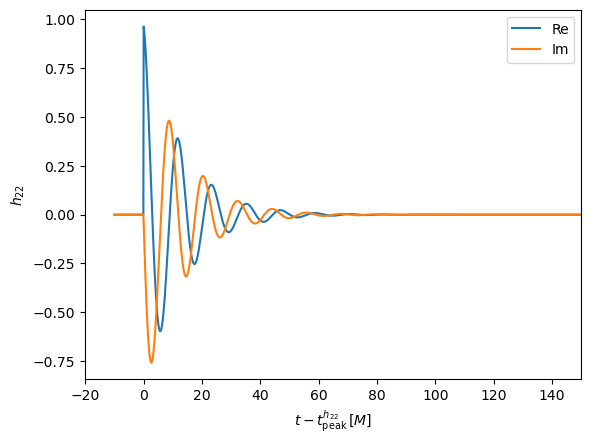

In [4]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h22), label='Re')
ax.plot(h.t, np.imag(h22), label='Im')

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-20,150);

In [5]:
# QNMs we want to fit for. The format is (ell, m, n, sign), where sign is +1 
# for "regular" (positive real part) modes, and -1 is for "mirror" (negative 
# real part) modes.
qnms = [(2,2,0,1), (3,2,0,1)]

# Spherical modes we want to fit to. The format is (ell, m).
spherical_modes = [(2,2)]

# Ringdown start time
t0 = 0.

# Perform the fit
best_fit = qnmfits.fit(
    data=h,
    chif=chif, 
    Mf=Mf,
    qnms=qnms,
    spherical_modes=spherical_modes,
    t0=t0
)

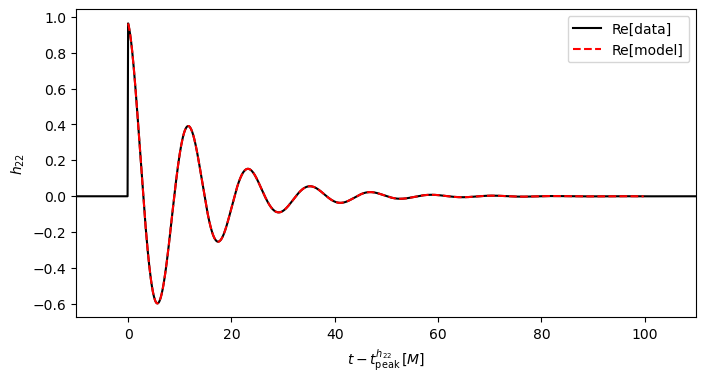

In [6]:
# Plot the best-fit model against the data

h_best_fit = best_fit['model']
h22_best_fit = h_best_fit.data[:, h_best_fit.index(2,2)]

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(h.t, np.real(h22), c='k', label='Re[data]')
ax.plot(
    h_best_fit.t, 
    np.real(h22_best_fit), 
    c='r', 
    ls='--',
    label='Re[model]'
)

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-10, 110);

In [7]:
best_fit['mismatch']

3.3306690738754696e-16

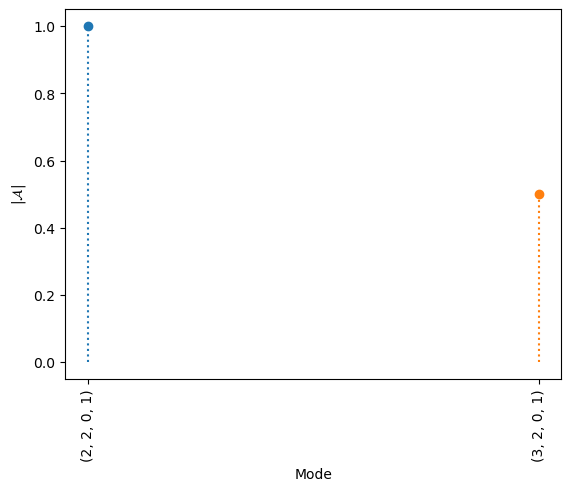

In [8]:
# Plot the best-fit mode amplitudes

amplitudes = [abs(best_fit['amplitudes'][label]) for label in qnms]
labels = [str(label) for label in qnms]

# x-axis values, useful for plotting
x = np.arange(len(amplitudes))
    
fig, ax = plt.subplots()

for i in range(len(amplitudes)):
    ax.plot(
        [x[i],x[i]], [0,amplitudes[i]], color=f'C{i}', marker='o', 
        markevery=(1,2), linestyle=':')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=90)

ax.set_xlabel('Mode')
ax.set_ylabel('$|\mathcal{A}|$');

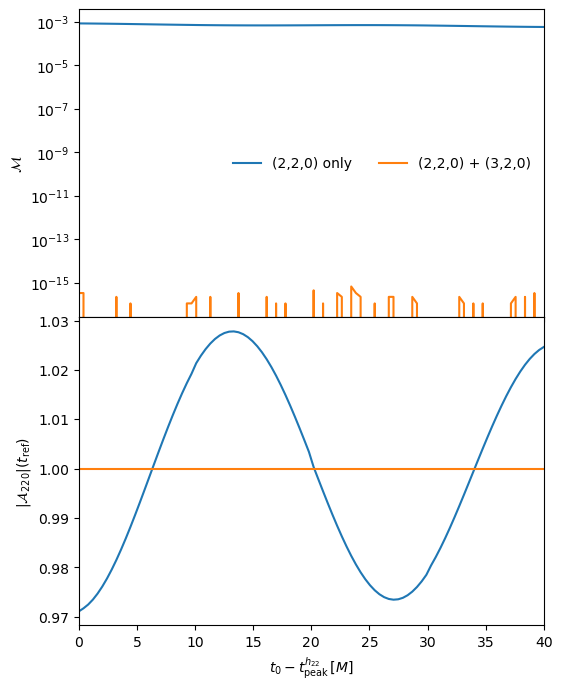

In [9]:
# Perform the fit with the fundamental mode only, and the correct model
qnm_list = [[(2,2,0,1)], [(2,2,0,1), (3,2,0,1)]]
labels = ['(2,2,0) only', '(2,2,0) + (3,2,0)']

spherical_modes = [(2,2)]

# The start times to use
t0_array = np.linspace(0, 40, 100)

# We can specify a reference time for when the QNM amplitudes are defined. This
# is useful for investigating mode stability.
t_ref = 0

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6,8), sharex=True)
fig.subplots_adjust(hspace=0)

# We will store the fundamental mode amplitudes for each fit to investigate
# mode stability
A220_dict = {}

for i, qnms in enumerate(qnm_list):

    # Store the fundamental mode amplitude for each start time, and the 
    # mismatch
    A220_dict[i] = []
    mm_list = []

    for t0 in t0_array:
        best_fit = qnmfits.fit(
            data=h,
            chif=chif,
            Mf=Mf,
            qnms=qnms,
            spherical_modes=spherical_modes,
            t0=t0,
            t_ref=t_ref
        )
        mm_list.append(best_fit['mismatch'])
        A220_dict[i].append(abs(best_fit['amplitudes'][2,2,0,1]))
        
    # Add to figure
    axs[0].semilogy(t0_array, mm_list, label=labels[i])
    axs[1].plot(t0_array, A220_dict[i])
    
# Plot limits and labels
axs[0].set_xlim(t0_array[0], t0_array[-1])
axs[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\, [M]$')
axs[0].set_ylabel('$\mathcal{M}$')
axs[1].set_ylabel('$|\mathcal{A}_{220}|(t_\mathrm{ref})$')

axs[0].legend(ncol=2, frameon=False);

### Working with surrogate waveforms

Here we use the [`gwsurrogate`](https://github.com/sxs-collaboration/gwsurrogate) package to load surrogate waveforms. We also need the remnant mass and spin for the QNM frequencies, which we can obtain with the [`surfnBH`](https://github.com/vijayvarma392/surfinBH/tree/master) package.

In [10]:
import gwsurrogate
import surfinBH

sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
sur_remnant = surfinBH.LoadFits('NRSur3dq8Remnant')

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
Loaded NRHybSur3dq8 model
Loaded NRSur3dq8Remnant fit.


We perform fits to the $(2,2)$ and $(3,3)$ modes for a range of mass ratios. As a check we can compare the measured amplitudes to the predictions in [Borhanian et al. (2020)](https://arxiv.org/abs/1901.08516) (this is how [Capano et al. (2023)](https://arxiv.org/abs/2105.05238) converted measurements of the $A_{220}$ and $A_{330}$ QNMs in GW190521 to a mass ratio).

In [11]:
qnms = [(2,2,0,1), (3,3,0,1)]
spherical_modes = [(2,2), (3,3)]

t0 = 30

# Lists to store the measured amplitudes
A220 = []
A330 = []

# We will fit to NRHybSur3dq8 waveforms with these mass ratios and spins
q_array = np.arange(1, 8.1, 0.2)
chi1 = [0, 0, 0]
chi2 = [0, 0, 0]

# Times for the surrogate
times = np.linspace(-100, 130, 2500, endpoint=False)

for q in q_array:

    # Obtain remnant properties for this mass ratio
    Mf, chif, vf, Mf_err, chif_err, vf_err = sur_remnant.all(q, chi1, chi2)
    chif_mag = np.linalg.norm(chif)

    # Initialize the surrogate. We shift the times so that t=0 corresponds to
    # the peak of the absolute value of the (2,2) mode.
    t, data, _ = sur(q, chi1, chi2, times=times, f_low=0)  
    t -= t[np.argmax(np.abs(data[2,2]))]

    # The dictionary of modes can be passed directly to this function to create
    # a WaveformModes object
    h = dict_to_WaveformModes(times=t, data=data)

    # Perform the fit
    best_fit = qnmfits.fit(
        data=h,
        chif=chif_mag, 
        Mf=Mf,
        qnms=qnms,
        spherical_modes=spherical_modes,
        t0=t0
    )

    A220.append(abs(best_fit['amplitudes'][2,2,0,1]))
    A330.append(abs(best_fit['amplitudes'][3,3,0,1]))

A220 = np.array(A220)
A330 = np.array(A330)

In [12]:
# To compare to Borhanian et al. we need the symmetric mass ratio eta and a
# mass asymmetry parameter delta:
eta_array = q_array/(1+q_array)**2
delta_array = np.sqrt(1-4*eta_array)

# The (2,2) mode amplitude is given by Eq. 3.2a in Borhanian et al. I have just
# chosen a value of alpha22 which works reasonably well.
alpha22 = 0.29

# The (3,3) amplitude is given by Eq. 3.2c. I have again chosen alpha33 myself.
alpha33 = 0.46

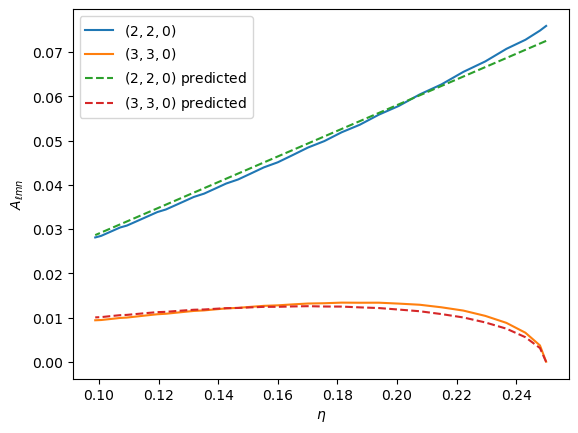

In [13]:
fig, ax = plt.subplots()

ax.plot(eta_array, A220, label='$(2,2,0)$')
ax.plot(eta_array, A330, label='$(3,3,0)$')

ax.plot(
    eta_array, 
    alpha22*eta_array, 
    linestyle='--', 
    label='$(2,2,0)$ predicted'
)
ax.plot(
    eta_array, 
    alpha33*A220*delta_array, 
    linestyle='--', 
    label='$(3,3,0)$ predicted'
)

ax.set_xlabel('$\eta$')
ax.set_ylabel('$A_{\ell m n}$')

ax.legend();